# 5. Tokenization

## Objetivo

- Læs alumnæs entenderán la importancia de la tokenización en un pipeline de NLP
- Como varía un corpus sin tokenizar y uno tokenizado
- Explorar métodos de *Subword tokenization* como: *BPE*, *WordPiece* y *Unigram*

## Tokenization

- Buscamos tener unidades de información para representar una lengua
    - Transformar nuestro texto crudo en datos que pueda procesar nuestro modelo
- La unidad más intuitiva son las palabras alfa-numericas separadas por
espacios (tokens)
- Segmentación de texto en *tokens* de ahí el nombre *tokenization*
    - Es una parte fundamental de un *pipeline* de *NLP*

In [ ]:
"Mira mamá estoy en la tele".split()

['Mira', 'mamá', 'estoy', 'en', 'la', 'tele']

## Word-based tokenization

- Fácil de implementar (`.split()`)
- Se pueden considerar los signos de puntuación agregando reglas simples

In [199]:
import re
text = "Let's get started son!!!"
re.findall(r"['!]|\w+", text)

['Let', "'", 's', 'get', 'started', 'son', '!', '!', '!']

### Problem?

<img src="http://images.wikia.com/battlebears/images/2/2c/Troll_Problem.jpg" with="250" height="250">

- Vocabularios gigantescos difíciles de procesar
- Generalmente, entre más grande es el vocabulario más pesado será nuestro modelo

**Ejemplo:**
- Si queremos representaciones vectoriales de nuestros tokens obtendríamos vectores distintos para palabras similares
    - niño = `v1(39, 34, 5,...)`
    - niños = `v2(9, 4, 0,...)`
    - niña = `v3(2, 1, 1,...)`
    - ...
- Tendríamos tokens con bajísima frecuencia
    - merequetengue = `vn(0,0,1,...)`

### Una Solución: Stemming/Lemmatization (AKA la vieja confiable)

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fi.ytimg.com%2Fvi%2FfxobA3YJCpk%2Fmaxresdefault.jpg&f=1&nofb=1&ipt=962ac292fba0c909d09a3f795a98775d24e22680fb502a2a5142d9c534bd2137&ipo=images" with="250" height="250">


In [200]:
import nltk
from nltk.corpus import brown
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [201]:
from collections import Counter

brown_corpus = [word for word in brown.words() if re.match("\w", word)]
print(brown_corpus[0])
print("Tokens:", len(brown_corpus))
print("Tipos:", len(Counter(brown_corpus)))

sub_brown_corpus = brown_corpus[:100000]
print("Sub brown_corpus tipos:", len(Counter(sub_brown_corpus)))

The
Tokens: 1012528
Tipos: 55640
Sub brown_corpus tipos: 15225


In [202]:
sub_brown_corpus[-20:]

['This',
 'would',
 'be',
 'cheaper',
 'to',
 'operate',
 'and',
 'could',
 'be',
 'used',
 'for',
 'cruises',
 'during',
 'the',
 'lean',
 'winter',
 'months',
 'Also',
 'under',
 'consideration']

In [203]:
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm

2023-10-09 22:16:28.419139: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 40.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2023-10-09 22:16:46.449393: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 47.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [204]:
import spacy

def lemmatize(words: list, lang="en") -> list:
    model = "en_core_web_sm" if lang == "en" else "es_core_news_sm"
    nlp = spacy.load(model)
    nlp.max_length = 1500000
    lemmatizer = nlp.get_pipe("lemmatizer")
    return [token.lemma_ for token in nlp(" ".join(words))]

In [206]:
print("tipos (Vanilla):", len(Counter(sub_brown_corpus)))
print("Tipos (Lemmatized):", len(Counter(lemmatize(sub_brown_corpus))))

tipos (Vanilla): 15225
Tipos (Lemmatized): 11316


- eats -> eat
- eating -> eat
- eated -> eat
- ate -> eat

### More problems?

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fpreview.redd.it%2Fjoonhzw1sjq31.png%3Fwidth%3D960%26crop%3Dsmart%26auto%3Dwebp%26s%3D3725297033765336276d49958089880e3f64d288&f=1&nofb=1&ipt=fdcf7c99c6a13417957a3832a14ca0f7ac4a70fc906fec79997bcb9795e31054&ipo=images" width="250" height="250">

- Métodos dependientes de las lenguas
- Se pierde información
- Ruled-based (?)

## Subword-tokenization

- Segmentación de palabras en unidades más pequeñas (*sub-words*)
- Obtenemos tipos menos variados pero con mayores frecuencias
    - Esto le gusta modelos basados en métodos estadísticos
- Palabras frecuentes no deberían separarse
- Palabras largas y raras debería descomponerse en sub-palabras significativas
- Hay métodos estadisticos que no requieren conocimiento a priori de las lenguas

In [208]:
text = "Let's do tokenization!"
result = ["Let's", "do", "token", "ization", "!"]
result

["Let's", 'do', 'token', 'ization', '!']

### Métodos para tokenizar


- *Byte-pair Encoding, BPE* (🤗, 💽)
- *Wordpiece* (🤗)
- *Unigram* (🤗)

In [209]:
!pip install sentencepiece
!pip install transformers

### BPE

- Segmenmentación iterativa, comienza segmentando en secuencias de caracteres
- Junta los pares más frecuentes (*merge operation*)
- Termina cuando se llega al número de *merge operations* especificado o número de vocabulario deseado (*hyperparams*, depende de la implementación)
- Introducido en el paper: [Neural Machine Translation of Rare Words with Subword Units, (Sennrich et al., 2015)](https://arxiv.org/abs/1508.07909)

In [ ]:
%%HTML
<iframe width="760" height="415" src="https://www.youtube.com/embed/HEikzVL-lZU"></iframe>

In [210]:
SENTENCE = "Let's do this tokenization to enable hypermodernization on my tokens tokenized 👁️!!!"

In [211]:
from transformers import GPT2Tokenizer
bpe_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
bpe_tokenizer.tokenize(SENTENCE)

['Let',
 "'s",
 'Ġdo',
 'Ġthis',
 'Ġtoken',
 'ization',
 'Ġto',
 'Ġenable',
 'Ġhyper',
 'modern',
 'ization',
 'Ġon',
 'Ġmy',
 'Ġtokens',
 'Ġtoken',
 'ized',
 'ĠðŁĳ',
 'ģ',
 'ï¸ı',
 '!!!']

In [212]:
encoded_tokens = bpe_tokenizer(SENTENCE)
encoded_tokens

{'input_ids': [5756, 338, 466, 428, 11241, 1634, 284, 7139, 8718, 23922, 1634, 319, 616, 16326, 11241, 1143, 50169, 223, 37929, 10185], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [213]:
bpe_tokenizer.decode(encoded_tokens["input_ids"])

"Let's do this tokenization to enable hypermodernization on my tokens tokenized 👁️!!!"

- En realidad GPT-2 usa *Byte-Level BPE*
    - Evitamos vocabularios de inicio grandes (Ej: unicode)
    - Usamos bytes como vocabulario base
    - Evitamos *Out Of Vocabulary, OOV* (aka `[UKW]`) (?)

### WordPiece

- Descrito en el paper: [Japanese and Korean voice search, (Schuster et al., 2012) ](https://static.googleusercontent.com/media/research.google.com/ja//pubs/archive/37842.pdf)
- Similar a BPE, inicia el vocabulario con todos los caracteres y aprende los merges
- En contraste con BPE, no elige con base en los pares más frecuentes si no los pares que maximicen la probabilidad de aparecer en los datos una vez que se agregan al vocabulario

$$score(a_i,b_j) = \frac{f(a_i,b_j)}{f(a_i)f(b_j)}$$

- Esto quiere decir que evalua la perdida de realizar un *merge* asegurandoce que vale la pena hacerlo

- Algoritmo usado en `BERT`

In [214]:
from transformers import BertTokenizer
SENTENCE = "🌽" + SENTENCE + "🔥"
wp_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
wp_tokenizer.tokenize(SENTENCE)

['[UNK]',
 "'",
 's',
 'do',
 'this',
 'token',
 '##ization',
 'to',
 'enable',
 'hyper',
 '##mo',
 '##dern',
 '##ization',
 'on',
 'my',
 'token',
 '##s',
 'token',
 '##ized',
 '[UNK]',
 '!',
 '!',
 '!',
 '[UNK]']

![](https://us-tuna-sounds-images.voicemod.net/9cf541d2-dd7f-4c1c-ae37-8bc671c855fe-1665957161744.jpg)

In [215]:
wp_tokenizer(SENTENCE)

{'input_ids': [101, 100, 1005, 1055, 2079, 2023, 19204, 3989, 2000, 9585, 23760, 5302, 25888, 3989, 2006, 2026, 19204, 2015, 19204, 3550, 100, 999, 999, 999, 100, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

### Unigram

- Algoritmo de subpword tokenization introducido en el paper: [Subword Regularization: Improving Neural Network Translation Models with Multiple Subword Candidates (Kudo, 2018)](https://arxiv.org/pdf/1804.10959.pdf)
- En contraste con BPE o WordPiece, este algoritmo inicia con un vocabulario muy grande y va reduciendolo hasta llegar tener un vocabulario deseado
- En cada iteración se calcula la perdida de quitar cierto elemento del vocabulario
    - Se quitará `p%` elementos que menos aumenten la perdida en esa iteración
- El algoritmo termina cuando se alcanza el tamaño deseado del vocabulario

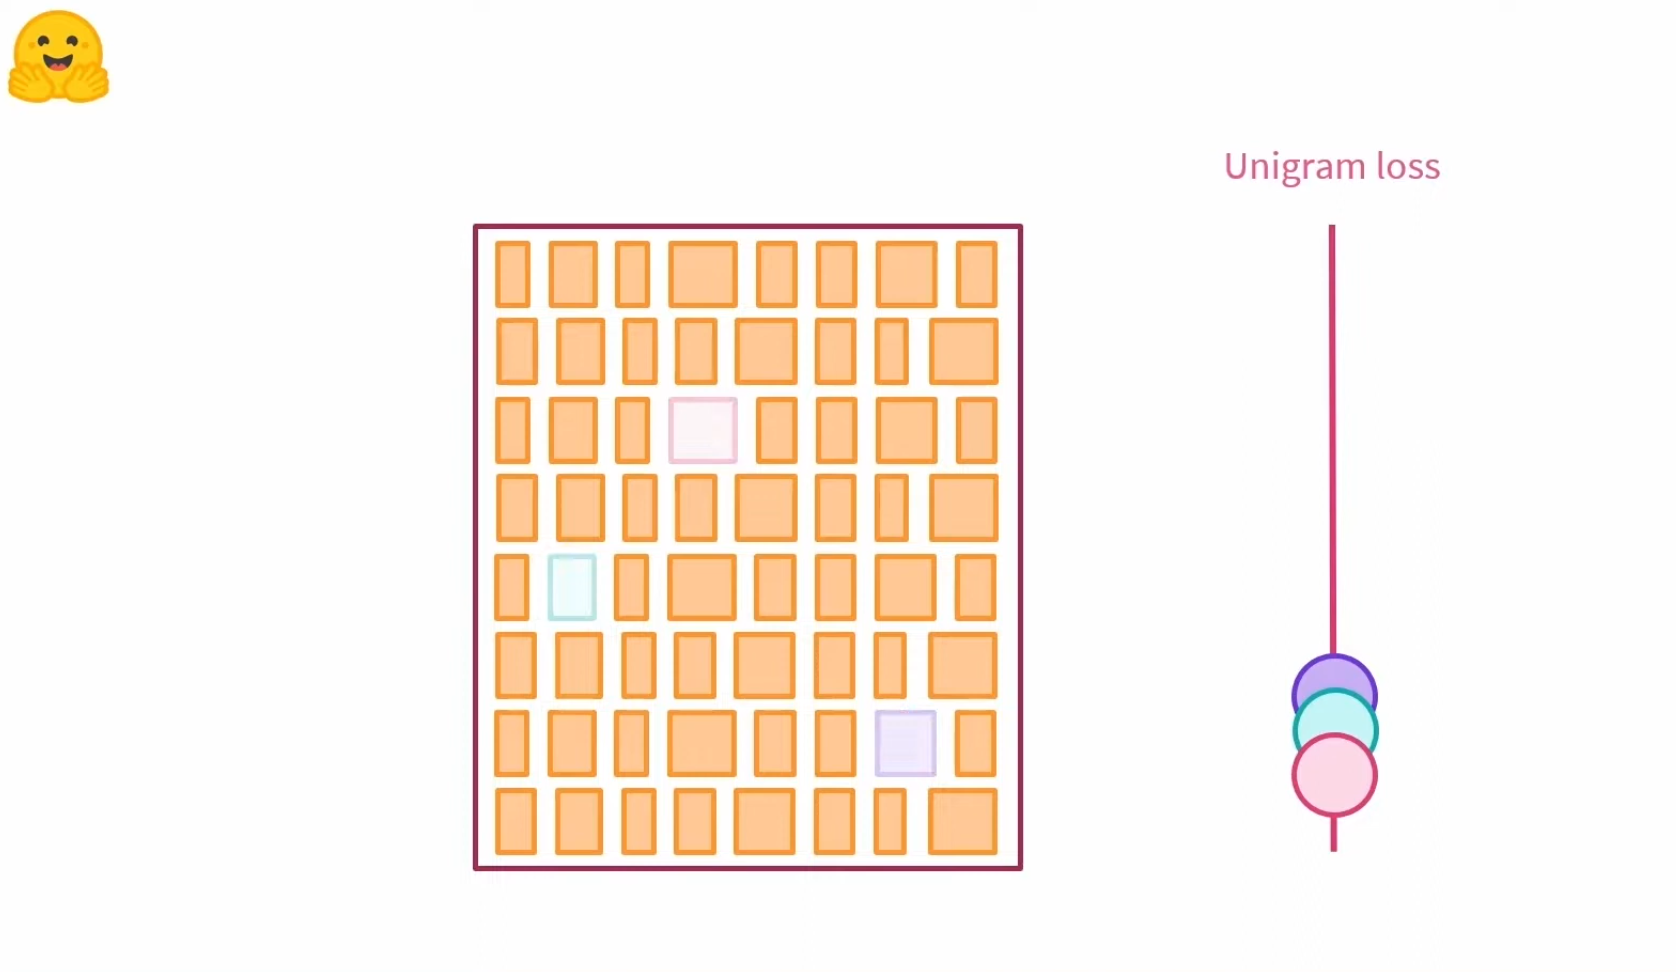

Sin embargo, *Unigram* no se usa por si mismo en algun modelo de Hugging Face:
> "Unigram is not used directly for any of the models in the transformers, but it’s used in conjunction with SentencePiece." - Hugging face guy


### SentencePiece


- No asume que las palabras estan divididas por espacios
- Trata la entrada de texto como un *stream* de datos crudos. Esto incluye al espacio como un caractér a usar
- Utiliza BPE o Unigram para construir el vocabulario

In [216]:
from transformers import XLNetTokenizer

tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
tokenizer.tokenize(SENTENCE)

['▁',
 '🌽',
 'Let',
 "'",
 's',
 '▁do',
 '▁this',
 '▁token',
 'ization',
 '▁to',
 '▁enable',
 '▁hyper',
 'modern',
 'ization',
 '▁on',
 '▁my',
 '▁token',
 's',
 '▁token',
 'ized',
 '▁',
 '👁️',
 '!!!',
 '🔥']

### Objetivo de los subword tokenizers


- Buscamos que modelos de redes neuronales tenga datos mas frecuentes
- Esto ayuda a que en principio "aprendan" mejor
- Reducir el numero de tipos (?)
- Reducir el numero de OOV (?)
- Reducir la entropia (?)

## Vamos a tokenizar 🌈

![](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fi.pinimg.com%2F736x%2F75%2F28%2Fe7%2F7528e71db75a37f0dcf5be8a54e0523f.jpg&f=1&nofb=1&ipt=d08ba1ed7fa9af9c3692703a667271740c22bb8e8f5b9f5f7acb44715e7d47d8&ipo=images)

### Corpus Español: CESS

In [217]:
nltk.download("cess_esp")

[nltk_data] Downloading package cess_esp to /root/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


True

In [218]:
from nltk.corpus import cess_esp as cess

cess_sents = cess.sents()
cess_words = cess.words()

In [219]:
len(cess_sents)

6030

In [220]:
cess_plain_text = " ".join([" ".join(sentence) for sentence in cess_sents])
cess_plain_text = re.sub(r"[-|_]", " ", cess_plain_text)

In [221]:
len(cess_plain_text)

1104297

In [222]:
cess_plain_text[300:600]

'EDF explicó a EFE que el proyecto para la construcción de Altamira 2 , al norte de Tampico , prevé la utilización de gas natural como combustible principal en una central de ciclo combinado que debe empezar a funcionar en mayo del 2002 . La electricidad producida pasará a la red eléctrica pública de'

### Corpus Inglés: Genesis

In [223]:
nltk.download('genesis')

[nltk_data] Downloading package genesis to /root/nltk_data...
[nltk_data]   Package genesis is already up-to-date!


True

In [224]:
from nltk.corpus import genesis

genesis_plain_text = genesis.raw()
genesis_words = genesis.words()

In [225]:
len(genesis_plain_text)

1420424

### Tokenizando el español con Hugging face

In [226]:
from transformers import AutoTokenizer

spanish_tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
spanish_tokenizer.tokenize(cess_plain_text[:100])

['el',
 'grupo',
 'estatal',
 'electri',
 '##ci',
 '##té',
 'de',
 'france',
 'fp',
 '##a',
 'ed',
 '##f',
 'fp',
 '##t',
 'anunció',
 'hoy',
 ',',
 'jueves',
 ',',
 'la',
 'compra',
 'del',
 '51',
 'por',
 'c']

In [227]:
cess_types = Counter(cess_words)
len(cess_types)

25464

In [229]:
cess_types.most_common(20)

[(',', 11420),
 ('de', 10234),
 ('la', 6412),
 ('.', 5866),
 ('que', 5552),
 ('el', 5199),
 ('en', 4340),
 ('y', 4235),
 ('*0*', 3883),
 ('"', 3038),
 ('los', 2963),
 ('a', 2953),
 ('del', 2257),
 ('se', 1884),
 ('las', 1832),
 ('un', 1815),
 ('con', 1494),
 ('por', 1456),
 ('una', 1396),
 ('su', 1291)]

In [230]:
cess_tokenized = spanish_tokenizer.tokenize(cess_plain_text)
cess_tokenized_types = Counter(cess_tokenized)
len(cess_tokenized_types)

Token indices sequence length is longer than the specified maximum sequence length for this model (236857 > 512). Running this sequence through the model will result in indexing errors


17818

In [232]:
cess_tokenized_types.most_common(30)

[('de', 11838),
 (',', 11622),
 ('*', 7767),
 ('la', 7164),
 ('.', 6534),
 ('el', 6090),
 ('que', 5948),
 ('en', 5001),
 ('y', 4441),
 ('0', 3972),
 ('a', 3634),
 ('los', 3230),
 ('"', 3050),
 ('del', 2516),
 ('se', 1957),
 ('las', 1957),
 ('por', 1949),
 ('un', 1906),
 ('fp', 1651),
 ('con', 1639),
 ('una', 1474),
 ('no', 1428),
 ('para', 1360),
 ('su', 1336),
 ('##a', 1301),
 ('al', 1241),
 ('##s', 1197),
 ('es', 1012),
 ('##t', 941),
 ('como', 788)]

In [233]:
cess_lemmatized_types = Counter(lemmatize(cess_words, lang="es"))
len(cess_lemmatized_types)

18109

In [234]:
cess_lemmatized_types.most_common(30)

[('el', 17905),
 (',', 11424),
 ('de', 10280),
 ('*', 7767),
 ('.', 5896),
 ('que', 5568),
 ('en', 4628),
 ('y', 4339),
 ('0', 3889),
 ('uno', 3631),
 ('él', 3565),
 ('"', 3043),
 ('a', 3006),
 ('ser', 2416),
 ('del', 2261),
 ('su', 1824),
 ('haber', 1724),
 ('con', 1545),
 ('por', 1526),
 ('no', 1354),
 ('para', 1313),
 ('-', 1240),
 ('al', 1011),
 ('este', 848),
 ('-Fpa-', 773),
 ('como', 724),
 ('-Fpt-', 676),
 ('más', 664),
 ('estar', 577),
 ('tener', 569)]

### Tokenizando para el ingles

In [235]:
genesis_types = Counter(genesis_words)
len(genesis_types)

25841

In [236]:
genesis_tokenized = wp_tokenizer.tokenize(genesis_plain_text)
genesis_tokenized_types = Counter(genesis_tokenized)
len(genesis_tokenized_types)

6501

In [237]:
genesis_tokenized_types.most_common(30)

[(',', 22823),
 ('.', 12549),
 ('and', 5751),
 ('##e', 5452),
 ('##a', 5355),
 ('##t', 5220),
 ('the', 4936),
 ('##s', 4487),
 ('e', 4289),
 ('de', 3882),
 (':', 3659),
 (';', 3642),
 ('a', 3472),
 ("'", 3461),
 ('##n', 3320),
 ('##i', 3064),
 ('ja', 2970),
 ('i', 2943),
 ('of', 2862),
 ('se', 2854),
 ('##u', 2732),
 ('to', 2661),
 ('##z', 2627),
 ('und', 2611),
 ('et', 2511),
 ('och', 2460),
 ('##r', 2417),
 ('"', 2415),
 ('##h', 2399),
 ('##m', 2351)]

In [238]:
genesis_lemmatized_types = Counter(lemmatize(genesis_words))
len(genesis_lemmatized_types)

24655

In [ ]:
genesis_lemmatized_types.most_common(20)

[(',', 22823),
 ('.', 12509),
 ('and', 5639),
 ('the', 4911),
 (';', 3641),
 (':', 3641),
 ("'", 3461),
 ('e', 3264),
 ('de', 3211),
 ('of', 2839),
 ('I', 2809),
 ('be', 2774),
 ('he', 2632),
 ('"', 2427),
 ('a', 2407),
 ('und', 2030),
 ('och', 2006),
 ('to', 1849),
 ('in', 1691),
 ('et', 1645)]

## Entrenando nuestro modelo con BPE

![](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmedia1.tenor.com%2Fimages%2Fd565618bb1217a7c435579d9172270d0%2Ftenor.gif%3Fitemid%3D3379322&f=1&nofb=1&ipt=9719714edb643995ce9d978c8bab77f5310204960093070e37e183d5372096d9&ipo=images)

In [239]:
!pip install subword-nmt

In [245]:
with open("cess_plain.txt", "w") as f:
    f.write(cess_plain_text)

In [246]:
!ls

axolotl_plain_normalized.txt   cess.model
axolotl_plain_test.txt	       cess_plain.txt
axolotl_plain_test.txt.txt     cess_test_tokenized.txt
axolotl_plain_vanilla.txt      sample_data
axolotl_vanilla.model	       spa_bible_tokenized.txt
axolotl_vanilla_tokenized.txt  spa-bible.txt


In [ ]:
!cat cess_plain.txt

In [248]:
!subword-nmt learn-bpe -s 300 < cess_plain.txt > cess.model

100% 300/300 [00:01<00:00, 210.48it/s]


In [249]:
!echo "Quisiera que procesaras esta maravillosa oración mi chavo" | subword-nmt apply-bpe -c cess.model

Q@@ ui@@ si@@ era que pro@@ c@@ es@@ ar@@ as esta mar@@ a@@ vi@@ ll@@ os@@ a or@@ ación m@@ i c@@ h@@ av@@ o


## Aplicandolo a otros corpus

In [250]:
BIBLE_FILE_NAMES = {"spa": "spa-x-bible-reinavaleracontemporanea", "eng": "eng-x-bible-kingjames"}

In [251]:
import requests

def get_bible_corpus(lang: str) -> str:
    file_name = BIBLE_FILE_NAMES[lang]
    r = requests.get(f"https://raw.githubusercontent.com/ximenina/theturningpoint/main/Detailed/corpora/corpusPBC/{file_name}.txt.clean.txt")
    return r.text

def write_plain_text_corpus(raw_text: str, file_name: str) -> None:
    with open(f"{file_name}.txt", "w") as f:
        f.write(raw_text)

In [252]:
BIBLE_FILE_NAMES['spa']

'spa-x-bible-reinavaleracontemporanea'

In [253]:
spa_bible_plain_text = get_bible_corpus('spa')
spa_bible_words = spa_bible_plain_text.replace("\n", " ").split()

In [254]:
spa_bible_words[:10]

['Principio',
 'del',
 'evangelio',
 'de',
 'Jesucristo',
 ',',
 'el',
 'Hijo',
 'de',
 'Dios']

In [255]:
len(spa_bible_words)

30073

In [256]:
spa_bible_types = Counter(spa_bible_words)
len(spa_bible_types)

3568

In [258]:
spa_bible_types.most_common(30)

[(',', 1946),
 ('.', 1099),
 ('y', 1031),
 ('de', 976),
 ('que', 924),
 ('a', 832),
 ('los', 605),
 ('la', 569),
 (':', 539),
 ('el', 507),
 ('se', 477),
 ('«', 423),
 ('»', 423),
 ('Jesús', 420),
 ('en', 413),
 ('lo', 355),
 ('le', 289),
 ('no', 268),
 ('les', 254),
 ('dijo', 252),
 ('con', 208),
 ('¿', 196),
 ('?', 195),
 ('al', 177),
 ('su', 170),
 ('para', 169),
 ('del', 164),
 ('¡', 158),
 ('!', 158),
 ('por', 143)]

In [259]:
spa_bible_lemmas_types = Counter(lemmatize(spa_bible_words, lang="es"))
len(spa_bible_lemmas_types)

2316

In [260]:
write_plain_text_corpus(spa_bible_plain_text, "spa-bible")

In [261]:
!subword-nmt apply-bpe -c cess.model < spa-bible.txt > spa_bible_tokenized.txt

In [262]:
with open("spa_bible_tokenized.txt", "r") as f:
    tokenized_text = f.read()
spa_bible_tokenized = tokenized_text.split()

In [263]:
spa_bible_tokenized[:10]

['P@@', 'r@@', 'in@@', 'ci@@', 'pi@@', 'o', 'del', 'ev@@', 'an@@', 'g@@']

In [264]:
len(spa_bible_tokenized)

62332

In [265]:
spa_bible_tokenized_types = Counter(spa_bible_tokenized)
len(spa_bible_tokenized_types)

392

In [267]:
spa_bible_tokenized_types.most_common(40)

[(',', 1946),
 ('a', 1611),
 ('y', 1156),
 ('o', 1126),
 ('.', 1099),
 ('de', 1095),
 ('que', 1029),
 ('los', 851),
 ('os', 801),
 ('t@@', 800),
 ('s@@', 772),
 ('es@@', 771),
 ('es', 737),
 ('d@@', 716),
 ('en', 702),
 ('c@@', 678),
 ('e', 657),
 ('la', 657),
 ('u@@', 654),
 ('di@@', 635),
 ('ó', 628),
 ('i@@', 613),
 ('an', 605),
 ('se', 581),
 ('el', 553),
 ('m@@', 551),
 ('r@@', 546),
 ('en@@', 541),
 (':', 539),
 ('J@@', 537),
 ('l@@', 507),
 ('lo', 505),
 ('e@@', 484),
 ('s', 481),
 ('er@@', 471),
 ('v@@', 466),
 ('ú@@', 445),
 ('n@@', 444),
 ('as', 439),
 ('g@@', 438)]

### Type-token Ratio (TTR)

- Una forma de medir la variazión del vocabulario en un corpus
- Este se calcula como $TTR = \frac{len(types)}{len(tokens)}$
- Puede ser útil para monitorear la variación lexica de un texto

In [268]:
print("Bible Spanish Information")
print("Tokens:", len(spa_bible_words))
print("Types (vanilla):", len(spa_bible_types))
print("Types (lemmatized)", len(spa_bible_lemmas_types))
print("Types (native BPE):", len(spa_bible_tokenized_types))
print("TTR (Vanilla):", len(spa_bible_types)/len(spa_bible_words))
print("TTR (BPE):", len(spa_bible_tokenized_types)/len(spa_bible_tokenized))

Bible Spanish Information
Tokens: 30073
Types (vanilla): 3568
Types (lemmatized) 2316
Types (native BPE): 392
TTR (Vanilla): 0.11864463139693412
TTR (BPE): 0.006288904575498942


## Entrenando BPE con corpus en Nahuatl

In [269]:
!pip install elotl

In [270]:
import elotl.corpus
axolotl = elotl.corpus.load("axolotl")

In [271]:
len(axolotl)

16117

In [272]:
train_rows_count = len(axolotl) - round(len(axolotl)*.30)

In [273]:
axolotl_train = axolotl[:train_rows_count]
axolotl_test = axolotl[train_rows_count:]

In [274]:
print("Axolotl train len:", len(axolotl_train))
print("Axolotl test len:", len(axolotl_test))
print("Total:", len(axolotl_test) + len(axolotl_train))

Axolotl train len: 11282
Axolotl test len: 4835
Total: 16117


In [275]:
axolotl_train[:3]

[['Vino a iluminar el sol y allí fue a ver a su',
  'tlaminako tonati uan noponi kiitato',
  '',
  'Lo que relatan de antes (cuentos tének y nahuas de la huasteca)'],
 ['Y así, cuando hizo su ofrenda de fuego, se sienta delante de los demás y una persona se queda junto a él.',
  'Auh in ye yuhqui in on tlenamacac niman ye ic teixpan on motlalia ce tlacatl itech mocaua.',
  '',
  'Vida económica de Tenochtitlan'],
 ['¿Si es jade, si es oro, acaso no tendrá que ir allá?',
  '¿In chalchihuitl, teocuitlatl, mach ah ca on yaz?',
  '',
  'Trece Poetas del Mundo Azteca']]

In [276]:
axolotl_words_vanilla_train = [word for row in axolotl_train for word in row[1].lower().split()]
len(axolotl_words_vanilla_train)

200302

In [277]:
axolotl_words_vanilla[:10]

['tlaminako',
 'tonati',
 'uan',
 'noponi',
 'kiitato',
 'auh',
 'in',
 'ye',
 'yuhqui',
 'in']

In [278]:
write_plain_text_corpus(" ".join(axolotl_words_vanilla_train), "axolotl_plain_vanilla")

In [279]:
!subword-nmt learn-bpe -s 300 < axolotl_plain_vanilla.txt > axolotl_vanilla.model

100% 300/300 [00:04<00:00, 65.21it/s] 


In [280]:
axolotl_test_words = [word for row in axolotl_test for word in row[1].lower().split()]
axolotl_test_types = Counter(axolotl_test_words)

In [281]:
axolotl_test_types.most_common(10)

[('yn', 5448),
 ('in', 4367),
 ('auh', 1359),
 ('ye', 1157),
 ('tlen', 998),
 ('ynic', 930),
 ('ihuan', 820),
 ('ipan', 780),
 ('ca', 754),
 ('de', 735)]

In [282]:
axolotl_singletons = [singleton for singleton in axolotl_test_types.items() if singleton[1] == 1]

In [283]:
len(axolotl_singletons)

19553

In [284]:
write_plain_text_corpus(" ".join(axolotl_test_words), "axolotl_plain_test")

In [285]:
!subword-nmt apply-bpe -c axolotl_vanilla.model < axolotl_plain_test.txt > axolotl_vanilla_tokenized.txt

In [286]:
with open("axolotl_vanilla_tokenized.txt") as f:
    axolotl_test_tokenized = f.read().split()

In [287]:
len(axolotl_test_tokenized)

256758

In [288]:
axolotl_test_tokenized[:10]

['o@@', 'me', 'a@@', 'xo@@', 'x@@', 'tla@@', 'n@@', 'tli', 'i@@', 'x']

In [289]:
axolotl_test_tokenized_types = Counter(axolotl_test_tokenized)

In [290]:
axolotl_test_tokenized_types.most_common(20)

[('yn', 5490),
 ('in', 5192),
 ('i@@', 5094),
 ('a@@', 4649),
 ('tla@@', 4323),
 ('o@@', 4124),
 ('qui@@', 3705),
 ('.', 3606),
 ('te@@', 3604),
 ('ti@@', 3512),
 ('ca@@', 3432),
 ('mo@@', 3061),
 ('ma@@', 3004),
 (',', 2768),
 ('to@@', 2716),
 ('l@@', 2634),
 ('y@@', 2622),
 ('no@@', 2363),
 ('co@@', 2223),
 ('h@@', 2164)]

In [291]:
print("Axolotl Information")
print("Tokens:", len(axolotl_test_words))
print("Types (vanilla):", len(axolotl_test_types))
print("Types (native BPE):", len(axolotl_test_tokenized_types))
print("TTR (Vanilla):", len(axolotl_test_types)/len(axolotl_test_words))
print("TTR (BPE):", len(spa_bible_tokenized_types)/len(axolotl_test_tokenized))
# TODO: Singletones comparation

Axolotl Information
Tokens: 86604
Types (vanilla): 25714
Types (native BPE): 451
TTR (Vanilla): 0.2969146921620249
TTR (BPE): 0.0015267294495205602


## Normalización

![](https://www.startpage.com/av/proxy-image?piurl=https%3A%2F%2Fimage.slidesharecdn.com%2Ffotolog-metroflog-blog-091114151901-phpapp02%2F95%2Ffotolog-metroflog-blog-25-728.jpg%3Fcb%3D1258212001&sp=1696882272Te74c680afd09150b556116c0c376ba0392e93aafa18a7d6206e6ec36e791f3c2)

In [292]:
METROFLOG_SENTENCE = "lEt'$ dó tHis béttëŕ :)"

In [293]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("huggingface-course/albert-tokenizer-without-normalizer")
tokenizer.convert_ids_to_tokens(tokenizer.encode(METROFLOG_SENTENCE))

['[CLS]',
 '▁l',
 '<unk>',
 't',
 "'",
 '$',
 '▁',
 'd',
 '<unk>',
 '▁',
 't',
 '<unk>',
 'is',
 '▁b',
 '<unk>',
 't',
 't',
 '<unk>',
 '▁',
 ':',
 ')',
 '[SEP]']

In [294]:
tokenizer = AutoTokenizer.from_pretrained("albert-large-v2")
tokenizer.convert_ids_to_tokens(tokenizer.encode(METROFLOG_SENTENCE))

['[CLS]', '▁let', "'", '$', '▁do', '▁this', '▁better', '▁', ':', ')', '[SEP]']

#### Y para lenguas de bajos recursos digitales?

- No hay muchos recursos :(
- Pero para el nahuatl esta `pyelotl` :)

#### Normalizando el Nahuatl

In [295]:
import elotl.nahuatl.orthography

In [296]:
# Tres posibles normalizadores: sep, inali, ack
# Sauce: https://pypi.org/project/elotl/

nahuatl_normalizer = elotl.nahuatl.orthography.Normalizer("sep")

In [297]:
axolotl[1][1]

'Auh in ye yuhqui in on tlenamacac niman ye ic teixpan on motlalia ce tlacatl itech mocaua.'

In [298]:
nahuatl_normalizer.normalize(axolotl[1][1])

'au in ye yujki in on tlenamakak niman ye ik teixpan on motlalia se tlakatl itech mokaua.'

In [299]:
nahuatl_normalizer.to_phones(axolotl[1][1])

'aw in ye yuʔki in on ƛenamakak niman ye ik teiʃpan on moƛalia se ƛakaƛ itet͡ʃ mokawa.'

## Práctica 5: Subword tokenization



**Fecha de entrega: 15 de Octubre 11:59pm**

- Investigar como medir la entropia de un texto
- Medir la entropía de la biblia en español y axolotl con y sin tokenizacion
    - Tokenizar con BPE native (`subword-nmt`)
- Imprimir en pantalla:
    - Entropia Nahuatl, Español sin tokenizar
    - Entropia Nahuatl, Español tokenizado
- Responder las preguntas:
    - ¿Aumento o disminuyó la entropia para los corpus?
        - Nahuatl
        - Español
    - ¿Qué significa que la entropia aumente o disminuya en un texto?
    - ¿Como influye la tokenizacion en la entropía de un texto?

#### Extra

- Realizar el proceso de normalización para el texto en Nahuatl
- Entrenar un modelo con el texto normalizado
    - Usando BPE Native (`subword-nmt`)
- Comparar typos, tokens, TTR con las versiones:
    - sin tokenizar
    - tokenizado sin normalizar (Vainilla)
    - tokenizado normalizado (NRMLZ)

```python
print("Axolotl Information: Normalized VS Vanilla")
print("Tokens (Vanilla):", ...)
print("Tokens (NRMLZ):", ...)
print("Types (Raw):", ...)
print("Types (Vanilla BPE):", ...)
print("Types (NRMLZ BPE):", ...)
print("TTR (Raw):", ...)
print("TTR (Vanilla BPE):", ...)
print("TTR (NRMLZ BPE):", ...)
```

### Referencias:

- [Corpora de la biblia en varios idiomas](https://github.com/ximenina/theturningpoint/tree/main/Detailed/corpora/corpusPBC)
- [Biblioteca nativa para BPE](https://github.com/rsennrich/subword-nmt)
- [Tokenizers Hugging face](https://huggingface.co/docs/transformers/tokenizer_summary)